# Water Ion Product

Determing KW at an arbitrary temperature

## Load Data

The data table from the above paper was made into a csv file (`Edwards1950.csv`). The file contains pH and k_obs values. It is read into a dataframe with the pH va;ues as the index series.  Then a $\log{(K_{obs})}$ series is created and a series for $[H^+]$

In [2]:
#!pip install uncertainties
#!pip install lmfit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit

import uncertainties as un               # tool set for handling uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

!mkdir plots

################################################################################
### Set global variables. Set flag accordingly
################################################################################

#github = True  
github = False  

if github:
    data_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/data/"
    image_path = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_10/images/"
    github_data_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"
    github_styles_location = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
else:
    data_path = "../Class_10/data/"
    image_path = "../Class_10/images/"
    github_data_location = "/Users/blink/github/LFER-QSAR/data/"
    github_styles_location = "/Users/blink/github/LFER-QSAR/styles/"

################################################################################
### Read data set. The fields are separated by commas; comments are enabled  
################################################################################

df = pd.read_csv(data_path + "Edwards1950.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
                 index_col="pH", 
                 comment = "#") 

################################################################################
### Process data  
################################################################################

df["logk"] = np.log10(df["k_obs"])        # get log(K) from K
df["H"]=10**(-df.index)                   # get [H] from pH
df.sort_values(by=['pH'], inplace=True)   # one value was out of order, sort to fix.

#display(df)

mkdir: plots: File exists


## The Components of the pH-rate Profile

There are at least three, perhaps four, reactions that contribute to the observed rate constant, $k_{obs}$. In the plot below we will fit each to the region of the plot that applies and find the values of the individual rate constants in piecemeal fashion. See the discussion document for more information.

## Curve Fitting the Model

The code below will curve fit the complete mathematical model. Two models are demonstrated, one uses three components, the better fitting model uses four and includes the water rate for the neutral species.

### Residual Plot

The code below will output a residual plot for the model fit above.

# Buffer Rate Plot
The code below reads the data fro the buffer rate experiment in the paper and plots the result.

## calculation Kw at 17 degrees

The reactions above were performed at $17\ ^\circ C$. What is the value of $K_W$ at $17\ ^\circ C$? A whitepaper on the NIST website presents an empirical formula for claulating the value of KW at temperatures between zero and 100 deg C. We need a data set for the density of water at those temperatures. I found a table on the website of a valve manufacturer in Britain.

log Kw at 17 deg is 17   -14.26712
Name: d g/cm, dtype: float64


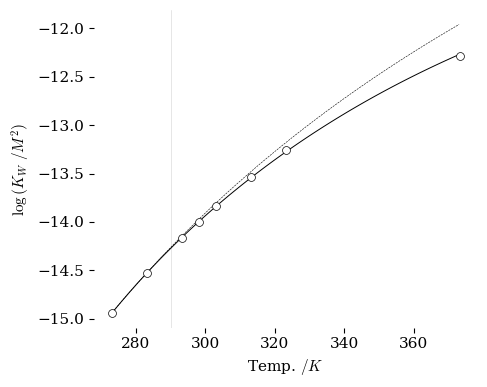

In [13]:
# https://srd.nist.gov/JPCRD/jpcrd181.pdf
# https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
# 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import linregress
from scipy.optimize import curve_fit


################################################################################
### Read data set. The fields are separated by commas; comments are enabled  ###
################################################################################
df2 = pd.read_csv("data/water_density2.csv", 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="pH", 
                 comment = "#") 
#display(df2.head())


# Data from https://www.chemguide.co.uk/physical/acidbaseeqia/kw.html
Temp = np.array([0,10,20,25,30,40,50,100]) + 273.15 

Kw = np.array([0.114e-14,
               0.293E-14,
               0.681E-14,
               1.008E-14,
               1.471E-14,
               2.916E-14,
               5.476E-14,
               51.30E-14,
           ])

# Empirical equation from https://srd.nist.gov/JPCRD/jpcrd181.pdf
A = -4.098
B = -3245.2
C = 2.2362E5
D = -3.984E7
E = 13.957
F = -1262.3
G = 8.5641E5

T = df2["temp degC"]+273
pw = df2["d g/cm"]/1000

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)
logKwCalcNISTnoPressure = A + B/T + C/T**2 + D/T**3 

################################################################################
### Plot the data and the line fit.   
################################################################################
plt.rcdefaults()
plt.style.use(github_styles_location + "tufte.mplstyle")        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  


ax.plot(T, logKwCalcNISTnoPressure, color='black', zorder=1, linestyle = "--", linewidth=0.4)
ax.plot(T, logKwCalcNIST, color='black', zorder=1, linewidth=0.7)

ax.scatter(Temp,np.log10(Kw), 
           marker = "o", s=32, 
           color="white", edgecolor = "black",
           linewidth = 0.5, zorder=3)

ax.set(ylabel=r"$\log{(K_W\ /M^{2})}$", 
       xlabel=r"Temp. $/K$",
#           xlim=[-0.01,0.35],                  
#          ylim=[-1.25,-0.7]
      
      )
ax.axvline(17+273.15, linewidth = 0.4, color = "lightgray", zorder=0)


T=17+273.15
line = df2.loc[df2["temp degC"]==17]
pw = line["d g/cm"]/1000

logKwCalcNIST = A + B/T + C/T**2 + D/T**3 + (E + F/T + G/T**2)*np.log10(pw)

KW17 = logKwCalcNIST
print(f"log Kw at 17 deg is {KW17}")

plt.savefig("plots/KW_plot.pdf")
plt.show()